# Test model performance on adhesin motifs not previously encountered

### Count sequences per category

In [8]:
from Bio import SeqIO
import os
import copy

ADH_25 = './data/sequences/processed_sequences/adhesin_25_final.fasta'
ADH = "./data/sequences/raw_sequences/adhesins.fa"


In [9]:
# initiate dictionaries with all sequences from all motifs
sequence_dictionary_full = {}
dir_ = './data/sequences/raw_sequences/'
for file in os.listdir(dir_):
    if len(file) < 11:
        motif_name = file.split('.')[0]
        motif_sequences = list(SeqIO.parse(os.path.join(dir_, file), 'fasta'))
        sequence_dictionary_full[motif_name] = {seq.id:0 for seq in motif_sequences}
sequence_dictionary_25 = copy.deepcopy(sequence_dictionary_full)

In [10]:
# fill dictionaries
adh_sequences = list(SeqIO.parse(ADH, 'fasta'))
for seq in adh_sequences:
    for motif in sequence_dictionary_full:
        if seq.id in sequence_dictionary_full[motif]:
            sequence_dictionary_full[motif][seq.id] = 1

adh_25_sequences = list(SeqIO.parse(ADH_25, 'fasta'))
for seq in adh_25_sequences:
    for motif in sequence_dictionary_25:
        if seq.id in sequence_dictionary_25[motif]:
            sequence_dictionary_25[motif][seq.id] = 1

In [11]:
# count
print('Protein count per motif before and after 25% cleaning:')
for motif in sequence_dictionary_25:
    count_full = sum(sequence_dictionary_full[motif].values())
    count_25 = sum(sequence_dictionary_25[motif].values())
    print(f'{motif} {count_full} {count_25}')

Protein count per motif before and after 25% cleaning:
PF08363 62 5
PF05737 529 71
PF08829 2 1
PF18220 10 2
PF17480 1 0
PF12799 7356 1559
PF18573 565 66
PF03212 507 84
PF07979 2 1
PF02216 5 2
PF15403 2 1
PF18651 142 32
PF05658 1488 12
PF08341 844 91
PF07675 312 56
PF18304 8 1
PF09160 50 1
PF18652 107 9
PF09403 29 10
PF18873 8 1
PF18483 600 201
PF10425 50 6
PF11966 16 1
PF15401 7 1
PF07691 3997 492


### Protein length distributions

In [40]:
ADH = "./data/sequences/raw_sequences/adhesins.fa"
ADH_25 = './data/sequences/processed_sequences/adhesin_25_final.fasta'
NON_ADH = './data/sequences/raw_sequences/non_adhesins.fa'
NON_ADH_25 = './data/sequences/processed_sequences/non_adhesin_25_final.fasta'

In [41]:
adhesin_sequences = list(SeqIO.parse(ADH, 'fasta'))
adhesin_sequences_25 = list(SeqIO.parse(ADH_25, 'fasta'))

print(f'{len(adhesin_sequences)} adhesins before cleaning\n\
{len(adhesin_sequences_25)} adhesin after 25% identity cleaning and removal of test sequences.')

16699 adhesins before cleaning
2700 adhesin after 25% identity cleaning and removal of test sequences.


In [42]:
# count after clustering
reduced_cleaned_non_adhesin_sequences = list(SeqIO.parse(NON_ADH_25, 'fasta'))
print(f'{len(reduced_cleaned_non_adhesin_sequences)} non adhesin sequences after random picking, 25% identity cleaning and removal of test sequences.')

2700 non adhesin sequences after random picking, 25% identity cleaning and removal of test sequences.


In [43]:
# verify sequence lengh in datasets
import matplotlib.pyplot as plt

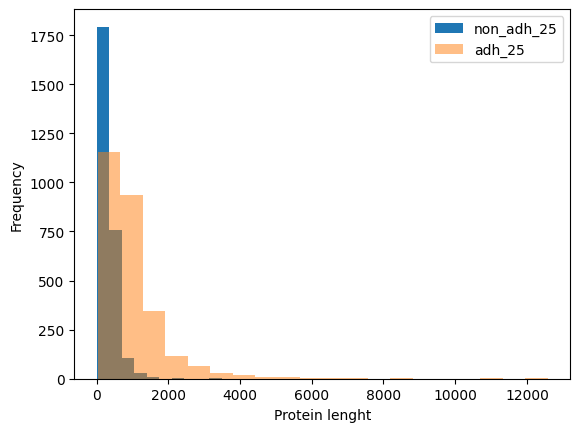

Adhesins mean lengh: 1020 aa, non adhesin mean lengh: 319 aa


In [44]:
non_adh_25 = list(SeqIO.parse(NON_ADH_25, 'fasta'))
adh_25 = list(SeqIO.parse(ADH_25, 'fasta'))

non_adh_25_lengh=[]
for protein in non_adh_25:
    non_adh_25_lengh.append(len(protein.seq))
    
adh_25_lengh=[]
for protein in adh_25:
    adh_25_lengh.append(len(protein.seq))
    
plt.hist(non_adh_25_lengh, label='non_adh_25')
plt.hist(adh_25_lengh, 20, alpha=0.5, label='adh_25')
plt.xlabel('Protein lenght')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# the mean lengh of adhesin proteins is 1200 vs 320 of non adhesins
print(f'Adhesins mean lengh: {int(sum(adh_25_lengh)/len(adh_25_lengh))} aa, non adhesin mean lengh: \
{int(sum(non_adh_25_lengh)/len(non_adh_25_lengh))} aa')

### Asses model perfomance on different datasets

In [12]:
import numpy as np
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from Bio import SeqIO

2023-02-18 12:54:12.390865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 12:54:12.743280: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-18 12:54:12.831162: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-18 12:54:12.831207: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [16]:
def from_files_to_vectors(fasta_path, motif='', motif_dictionary=sequence_dictionary_25, positive=True):
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'pos_25.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'neg_25.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    if positive:
        names = "_pos"
    else:
        names = "_neg"
    for i in range(len(files)):
        files[i] += names
    datasets = [[] for el in files]
    motif_datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    return datasets
                # place proteins with a given motif in a specific dataset
                if positive:
                    if information[0] in motif_dictionary[motif].keys():
                        motif_datasets[i].append(np.array([float(el) for el in information[1:]]))
                    else:
                        datasets[i].append(np.array([float(el) for el in information[1:]]))
                else:    
                    datasets[i].append(np.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = np.array(datasets[i])
        if positive:
            motif_datasets[i] = np.array(motif_datasets[i])
    if positive:
        
        return datasets, motif_datasets
    return datasets

In [14]:
from tensorflow.keras import regularizers
import pandas as pd

class neural_network:
    def __init__(self, K):
        input = tensorflow.keras.Input(shape=(K,))
        
        dense = tensorflow.keras.layers.Dense(units=10, 
                                                activation='sigmoid',
                                                kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
                                                bias_regularizer=regularizers.L2(1e-3),
                                                activity_regularizer=regularizers.L2(1e-3))(input)
        #norm = tensorflow.keras.layers.BatchNormalization()(dense)
        #drop = tensorflow.keras.layers.Dropout(.1)(dense)
        #dense = tensorflow.keras.layers.Dense(10, activation='sigmoid')(drop)
        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(dense)

        model = tensorflow.keras.models.Model(inputs=input, outputs=output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics='accuracy')
        self.model = model


def run_model_motifs(pos_datasets, neg_datasets, motif_datasets, projection_matrix='projection_matrix.npy',\
                    model_weights = 'ac_motif.h5', training_means = np.load('./mean.npy'), \
                    training_std_devs = np.load('./std.npy')):
    """Run multiple cross validations over different motifs to test model generalization"""
    
    # pre processing
    y_pos = np.ones(pos_datasets[0].shape[0])
    y_neg = np.zeros(neg_datasets[0].shape[0])
    y_motif = np.ones(motif_datasets[0].shape[0])
    
    # attach datasets in order to obtain a matrix of (n, 20+400+39+39+195) features
    rows = 0
    n_pos = y_pos.shape[0]
    n_neg = y_neg.shape[0]
    rows = n_pos + n_neg
    # feature vectors dimensions
    columns = 0
    for i in range(len(pos_datasets)):
        tmp_dim = pos_datasets[i].shape[1]
        columns += tmp_dim
    # data matrix to process
    X = np.zeros((rows, columns))
    for i in range(n_pos):
        X[i] = np.concatenate([pos_datasets[j][i] for j in range(5)])
    for i in range(n_neg):
        X[n_pos+i] = np.concatenate([neg_datasets[j][i] for j in range(5)])
    # same for motif dataset
    X_motifs = np.zeros((y_motif.shape[0], columns))
    for i in range(y_motif.shape[0]):
        X_motifs[i] = np.concatenate([motif_datasets[j][i] for j in range(5)])
    
    # permutation
    np.random.seed(42)
    y = np.concatenate((y_pos, y_neg), axis=0)
    c = np.random.permutation(np.arange(y.shape[0]))
    y = y[c]
    X = X[c] 
    
    # split datasets for training 
    X_train = X[:int(X.shape[0]*.5)]
    X_val = X[int(X.shape[0]*.5):int(X.shape[0]*.75)]
    X_test = X[int(X.shape[0]*.75):]

    y_train = y[:int(y.shape[0]*.5)]
    y_val = y[int(y.shape[0]*.5):int(y.shape[0]*.75)]
    y_test = y[int(y.shape[0]*.75):]
    
    # standardize
    def standardize(dataset):
        """Standardize dataset"""
        std_dataset = np.zeros(dataset.shape)
        for j in range(dataset.shape[1]):
            column = dataset[:,j]
            std_dataset[:,j] = (column - training_means[j]) / training_std_devs[j]
        return std_dataset
    
    stdX = standardize(X_train)
    stdX_val = standardize(X_val)    
    stdX_test = standardize(X_test)    
    stdX_motif = standardize(X_motifs)
    
    # project matrices
    projection_matrix = np.load(projection_matrix)
    X_train = stdX.dot(projection_matrix)
    X_val = stdX_val.dot(projection_matrix)
    X_test = stdX_test.dot(projection_matrix)
    X_motif = stdX_motif.dot(projection_matrix)
    
    # initiate model
    nn = neural_network(400)
    # train
    history = nn.model.fit(
    x=X_train, 
    y=y_train,
    batch_size=64,
    epochs=1000,
    verbose=0,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[tensorflow.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    patience=5
        )])
    
    model_test = nn.model.evaluate(x=X_test, y=y_test)
    print(model_test)
    nn.model.save('ac_motif.h5')
    model = tensorflow.keras.models.load_model(model_weights)
    motif_test = model.evaluate(x=X_motif, y=y_motif)
    print(motif_test)
    return model_test, motif_test

In [19]:
outlist = []
for motif in sequence_dictionary_25:
    pos_datasets, motif_datasets = from_files_to_vectors("./data/25_similarity/pos/", motif, positive=True)
    neg_datasets = from_files_to_vectors("./data/25_similarity/neg/", positive=False)
    if sum(sequence_dictionary_25[motif].values()) > 0:
        model_test, motif_test = run_model_motifs(pos_datasets, neg_datasets, motif_datasets)
        outlist.append([motif, sum(sequence_dictionary_25[motif].values()), model_test[1],\
                        motif_test[1]])

43/43 [==============================] - 0s 620us/step - loss: 0.2375 - accuracy: 0.9385
[0.23754002153873444, 0.9384729266166687]
1/1 [==============================] - 0s 74ms/step - loss: 0.4264 - accuracy: 0.8000
[0.4264104962348938, 0.800000011920929]
42/42 [==============================] - 0s 636us/step - loss: 0.2388 - accuracy: 0.9340
[0.23877550661563873, 0.9339835047721863]
3/3 [==============================] - 0s 1ms/step - loss: 0.1595 - accuracy: 0.9577
[0.1595037281513214, 0.9577465057373047]
43/43 [==============================] - 0s 650us/step - loss: 0.2265 - accuracy: 0.9430
[0.22653116285800934, 0.9429629445075989]
1/1 [==============================] - 0s 75ms/step - loss: 0.0787 - accuracy: 1.0000
[0.07868579030036926, 1.0]
43/43 [==============================] - 0s 658us/step - loss: 0.2222 - accuracy: 0.9496
[0.22222235798835754, 0.9496296048164368]
1/1 [==============================] - 0s 74ms/step - loss: 0.6905 - accuracy: 0.5000
[0.6905139088630676, 0.5]

In [37]:
df = pd.DataFrame(outlist, columns = ['motif', 'proteins', 'model_accuracy', 'model_accuracy_on_motif'])
print(f'The weighted average accuracy on unseen adhesin motifs is') 
print(f'{round(np.average(df["model_accuracy_on_motif"], weights=df["proteins"]), 2)*100} %')
df

The weighted average accuracy on unseen adhesin motifs is
61.0 %


,motif,proteins,model_accuracy,model_accuracy_on_motif
0,PF08363,5,0.938473,0.800000
1,PF05737,71,0.933984,0.957747
2,PF08829,1,0.942963,1.000000
3,PF18220,2,0.949630,0.500000
4,PF12799,1559,0.944849,0.456062
5,PF18573,66,0.931035,0.590909
6,PF03212,84,0.938299,0.964286
7,PF07979,1,0.937037,1.000000
8,PF02216,2,0.940741,0.000000
9,PF15403,1,0.941481,0.000000


<AxesSubplot: >

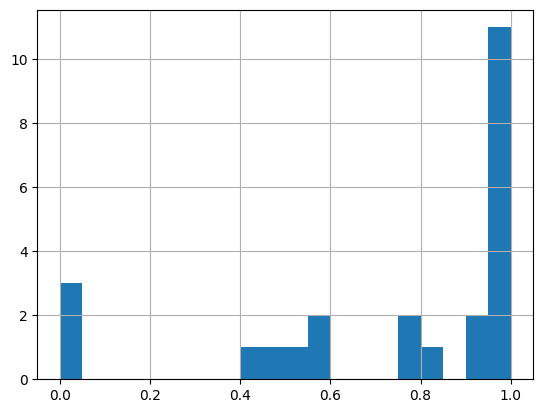

In [38]:
df['model_accuracy_on_motif'].hist(bins=20)